In [1]:
pip install -U gensim

Note: you may need to restart the kernel to use updated packages.


In [1]:
import gensim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 100)
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn import model_selection, naive_bayes, svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

In [2]:
random_state = 100
np.random.seed(random_state)

In [4]:
# Loading dataset
df2 = pd.read_csv(r"C:\Users\zahin\Full_SACv2.csv",encoding='unicode_escape')
df2['mr_report'] = df2['mr_report'].astype(str)

df2.head()

,Unnamed: 0,Outcome,mr_report
0,0,0,"Reason for Exam: CHRONIC, RECURRENT SEVERE LOWER BACKCAHE, STIFFNESS Â NEVE ROOT IMPINGMENT? ..."
1,1,1,TECHNIQUE: Sagittal T1 and T2 images of the lumbosacral spine were obtained with axial T1 and T2...
2,2,0,"TECHNIQUE:Â NoncontrastÂ MRIÂ ofÂ theÂ lumbarÂ spineÂ protocol,Â withÂ sagittalÂ T1Â andÂ T2Â..."
3,3,1,Narrative & Impression MR LUMBAR SPINE Reason for Exam: PLEASSANT LADY WITH A PAST HX OF BREAST ...
4,4,0,MRÂ THORACICÂ SPINEÂ Â Â Â Â ReasonÂ forÂ Exam:Â RECURRENTÂ LOWERÂ THORACICÂ ANDÂ LUMBARÂ P...


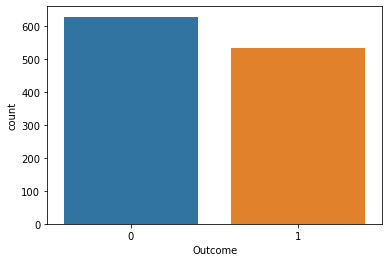

In [5]:
ax = sns.countplot(x="Outcome", data=df2)

In [19]:
# dropiing few negative outcomes to maintain balance
remove_n = 495
drop_indices = np.random.choice(df[(df.Outcome == 0)].index, remove_n, replace=False)
print(drop_indices)
df2 = df.drop(drop_indices)
df2.reset_index(inplace=True)
df2.shape

[341 599 249 116  60 275 756 606 129 167 743 721 514 493 668 479 482 660
 630 416 577 203 659 255  32 127 542 543 527 680 139 261  19 208  54 410
 695 241 313 166 164 509  46 465 523 234 661  51 408 726 406 409   5 716
 563 590 623 188 709 713 452 333 240 319 382 348 730  12 273 118  20 421
 376 170 707 586 268 569 282 686  38 507  79  76 284 364 571 560   2  58
 227 137 108 359  93 490  96 536 519 614  14 402 474  91 731 257 369 429
 486 352 425 204 481 169 312   9  61 585 302 462 495  59 648 387 596 574
 397 595 504 307 107 120 184 253   4 270 656 662 153 187 466 742  74 358
 394 544  52 715 734 345 162 644 719  78  98 181 458 579 213 412 604  31
 651 286  16 441 759 207 342 670 300 576 211 582 363 148 298 310 171 435
 366 331 667 160 168 537 131 230 642 476 478 747  25 103 449 502 288 635
 124  11 633 291 669 175 228 733 545  48 728 444 469 238 190 506 583 122
 528 518 339  70 318 155 538 152  15 646 415 428 380 354 448 608 568 330
 525  56 299 612 378  22 622 128 666 357 561 541  2

(267, 3)

In [7]:
# Cleaning data using the built in cleaner in gensim
df2['text_clean'] = df2['mr_report'].apply(lambda x: gensim.utils.simple_preprocess(x))
df2.head()

,Unnamed: 0,Outcome,mr_report,text_clean
0,0,0,"Reason for Exam: CHRONIC, RECURRENT SEVERE LOWER BACKCAHE, STIFFNESS Â NEVE ROOT IMPINGMENT? ...","[reason, for, exam, chronic, recurrent, severe, lower, backcahe, stiffness, neve, root, impingme..."
1,1,1,TECHNIQUE: Sagittal T1 and T2 images of the lumbosacral spine were obtained with axial T1 and T2...,"[technique, sagittal, and, images, of, the, lumbosacral, spine, were, obtained, with, axial, and..."
2,2,0,"TECHNIQUE:Â NoncontrastÂ MRIÂ ofÂ theÂ lumbarÂ spineÂ protocol,Â withÂ sagittalÂ T1Â andÂ T2Â...","[technique, noncontrastâ, mriâ, ofâ, theâ, lumbarâ, spineâ, protocol, withâ, sagittalâ, andâ, se..."
3,3,1,Narrative & Impression MR LUMBAR SPINE Reason for Exam: PLEASSANT LADY WITH A PAST HX OF BREAST ...,"[narrative, impression, mr, lumbar, spine, reason, for, exam, pleassant, lady, with, past, hx, o..."
4,4,0,MRÂ THORACICÂ SPINEÂ Â Â Â Â ReasonÂ forÂ Exam:Â RECURRENTÂ LOWERÂ THORACICÂ ANDÂ LUMBARÂ P...,"[mrâ, thoracicâ, spineâ, reasonâ, forâ, exam, recurrentâ, lowerâ, thoracicâ, andâ, lumbarâ, pain..."


# Logistic Regression: Five-fold cross-validation

In [8]:
k = 5
fold = 0

accuracy = 0
f1 = 0
precision = 0
recall = 0

folds = KFold(n_splits=k, random_state=None, shuffle=False)

for train_index, test_index in folds.split(df2['mr_report'], df2['Outcome']):
    fold += 1
    X_train, Y_train = df2['mr_report'][train_index], df2['Outcome'][train_index]
    X_test, Y_test = df2['mr_report'][test_index], df2['Outcome'][test_index]
    
    
    # Training the word2vec model
    w2v_model = gensim.models.Word2Vec(X_train, vector_size=100, window=5, min_count=2)
    
    # Generate aggregated sentence vectors based on the word vectors for each word in the sentence
    words = set(w2v_model.wv.index_to_key )
    X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_train])
    X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_test])
    
    X_train_vect_avg = []
    for v in X_train_vect:
        if v.size:
            X_train_vect_avg.append(v.mean(axis=0))
        else:
            X_train_vect_avg.append(np.zeros(100, dtype=float))
        
    X_test_vect_avg = []
    for v in X_test_vect:
        if v.size:
            X_test_vect_avg.append(v.mean(axis=0))
        else:
            X_test_vect_avg.append(np.zeros(100, dtype=float))
    
    
    # fit the training dataset on the LR
    lr = LogisticRegression(max_iter = 10000, class_weight = 'balanced', random_state=0)
    lr.fit(X_train_vect_avg, Y_train.values.ravel())

    # predicting the labels on validation dataset
    Y_pred = lr.predict(X_test_vect_avg)
        
    accuracy += accuracy_score(Y_pred, Y_test)/k
    f1 += f1_score(Y_pred, Y_test)/k
    precision += precision_score(Y_pred, Y_test)/k
    recall += recall_score(Y_pred, Y_test)/k
    
    #Specificity and Sensitivity
    tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp + fn)
    
    
    print(f"Fold {fold}")
    print(f"Accuracy -> {accuracy_score(Y_pred, Y_test):0.4f}")
    print(f"F1-Score -> {f1_score(Y_pred, Y_test):0.4f}")
    print(f"Precision -> {precision_score(Y_pred, Y_test):0.4f}")
    print(f"Recall -> {recall_score(Y_pred, Y_test):0.4f}")
    
    print(f"Specificity -> {specificity:0.4f}")
    print(f"Sensitivity -> {sensitivity:0.4f}")

C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/1237651010.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_train])
C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/1237651010.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_test])


Fold 1
Accuracy -> 0.7597
F1-Score -> 0.7813
Precision -> 0.8197
Recall -> 0.7463
Specificity -> 0.6937
Sensitivity -> 0.8197


C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/1237651010.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_train])
C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/1237651010.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_test])


Fold 2
Accuracy -> 0.7425
F1-Score -> 0.7638
Precision -> 0.8739
Recall -> 0.6783
Specificity -> 0.6230
Sensitivity -> 0.8739


C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/1237651010.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_train])
C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/1237651010.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_test])


Fold 3
Accuracy -> 0.7974
F1-Score -> 0.8171
Precision -> 0.8824
Recall -> 0.7609
Specificity -> 0.7080
Sensitivity -> 0.8824


C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/1237651010.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_train])
C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/1237651010.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_test])


Fold 4
Accuracy -> 0.7543
F1-Score -> 0.7654
Precision -> 0.8857
Recall -> 0.6739
Specificity -> 0.6457
Sensitivity -> 0.8857


C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/1237651010.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_train])


Fold 5
Accuracy -> 0.6767
F1-Score -> 0.6032
Precision -> 0.7403
Recall -> 0.5089
Specificity -> 0.6452
Sensitivity -> 0.7403


C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/1237651010.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_test])


In [9]:
print(f"Accuracy -> {accuracy:0.4f}")
print(f"F1-Score -> {f1:0.4f}")
print(f"Precision -> {precision:0.4f}")
print(f"Recall -> {recall:0.4f}")

Accuracy -> 0.7461
F1-Score -> 0.7462
Precision -> 0.8404
Recall -> 0.6737


# GNB: Five-fold cross-validation

In [10]:
k = 5
fold = 0

accuracy = 0
f1 = 0
precision = 0
recall = 0

folds = KFold(n_splits=k, random_state=None, shuffle=False)

for train_index, test_index in folds.split(df2['mr_report'], df2['Outcome']):
    fold += 1
    X_train, Y_train = df2['mr_report'][train_index], df2['Outcome'][train_index]
    X_test, Y_test = df2['mr_report'][test_index], df2['Outcome'][test_index]
    
    
    # Training the word2vec model
    w2v_model = gensim.models.Word2Vec(X_train, vector_size=100, window=5, min_count=2)
    
    # Generate aggregated sentence vectors based on the word vectors for each word in the sentence
    words = set(w2v_model.wv.index_to_key )
    X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_train])
    X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_test])
    
    X_train_vect_avg = []
    for v in X_train_vect:
        if v.size:
            X_train_vect_avg.append(v.mean(axis=0))
        else:
            X_train_vect_avg.append(np.zeros(100, dtype=float))
        
    X_test_vect_avg = []
    for v in X_test_vect:
        if v.size:
            X_test_vect_avg.append(v.mean(axis=0))
        else:
            X_test_vect_avg.append(np.zeros(100, dtype=float))
    
    
    # fit the training dataset on the LR
    gnb = GaussianNB()
    gnb.fit(X_train_vect_avg, Y_train.values.ravel())

    # predicting the labels on validation dataset
    Y_pred = gnb.predict(X_test_vect_avg)
        
    accuracy += accuracy_score(Y_pred, Y_test)/k
    f1 += f1_score(Y_pred, Y_test)/k
    precision += precision_score(Y_pred, Y_test)/k
    recall += recall_score(Y_pred, Y_test)/k
    
    #Specificity and Sensitivity
    tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp + fn)
    
    print(f"Fold {fold}")
    print(f"Accuracy -> {accuracy_score(Y_pred, Y_test):0.4f}")
    print(f"F1-Score -> {f1_score(Y_pred, Y_test):0.4f}")
    print(f"Precision -> {precision_score(Y_pred, Y_test):0.4f}")
    print(f"Recall -> {recall_score(Y_pred, Y_test):0.4f}")
    print(f"Specificity -> {specificity:0.4f}")
    print(f"Sensitivity -> {sensitivity:0.4f}")

C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/1570402453.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_train])
C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/1570402453.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_test])


Fold 1
Accuracy -> 0.6137
F1-Score -> 0.7188
Precision -> 0.9426
Recall -> 0.5808
Specificity -> 0.2523
Sensitivity -> 0.9426


C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/1570402453.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_train])
C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/1570402453.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_test])


Fold 2
Accuracy -> 0.5451
F1-Score -> 0.6513
Precision -> 0.8919
Recall -> 0.5130
Specificity -> 0.2295
Sensitivity -> 0.8919


C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/1570402453.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_train])
C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/1570402453.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_test])


Fold 3
Accuracy -> 0.6207
F1-Score -> 0.7197
Precision -> 0.9496
Recall -> 0.5795
Specificity -> 0.2743
Sensitivity -> 0.9496


C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/1570402453.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_train])
C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/1570402453.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_test])


Fold 4
Accuracy -> 0.5000
F1-Score -> 0.6234
Precision -> 0.9143
Recall -> 0.4729
Specificity -> 0.1575
Sensitivity -> 0.9143


C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/1570402453.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_train])


Fold 5
Accuracy -> 0.4655
F1-Score -> 0.5338
Precision -> 0.9221
Recall -> 0.3757
Specificity -> 0.2387
Sensitivity -> 0.9221


C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/1570402453.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_test])


In [11]:
print(f"Accuracy -> {accuracy:0.4f}")
print(f"F1-Score -> {f1:0.4f}")
print(f"Precision -> {precision:0.4f}")
print(f"Recall -> {recall:0.4f}")

Accuracy -> 0.5490
F1-Score -> 0.6494
Precision -> 0.9241
Recall -> 0.5044


# LR + SVM Ensemble: Five-fold cross-validation

In [12]:
k = 5
fold = 0

accuracy = 0
f1 = 0
precision = 0
recall = 0

folds = KFold(n_splits=k, random_state=None, shuffle=False)

for train_index, test_index in folds.split(df2['mr_report'], df2['Outcome']):
    fold += 1
    X_train, Y_train = df2['mr_report'][train_index], df2['Outcome'][train_index]
    X_test, Y_test = df2['mr_report'][test_index], df2['Outcome'][test_index]
    
    
    # Training the word2vec model
    w2v_model = gensim.models.Word2Vec(X_train, vector_size=100, window=5, min_count=2)
    
    # Generate aggregated sentence vectors based on the word vectors for each word in the sentence
    words = set(w2v_model.wv.index_to_key )
    X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_train])
    X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_test])
    
    X_train_vect_avg = []
    for v in X_train_vect:
        if v.size:
            X_train_vect_avg.append(v.mean(axis=0))
        else:
            X_train_vect_avg.append(np.zeros(100, dtype=float))
        
    X_test_vect_avg = []
    for v in X_test_vect:
        if v.size:
            X_test_vect_avg.append(v.mean(axis=0))
        else:
            X_test_vect_avg.append(np.zeros(100, dtype=float))
    
    clf1 = LogisticRegression(multi_class='multinomial', class_weight = 'balanced', random_state=0)
    clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
    clf3 = GaussianNB()
    
    # fit the training dataset on the LR
    eclf1 = VotingClassifier(estimators=[('lr', clf1), ('gnb', clf3)], voting='hard')
    eclf1.fit(X_train_vect_avg, Y_train.values.ravel())

    # predicting the labels on validation dataset
    Y_pred = eclf1.predict(X_test_vect_avg)
        
    accuracy += accuracy_score(Y_pred, Y_test)/k
    f1 += f1_score(Y_pred, Y_test)/k
    precision += precision_score(Y_pred, Y_test)/k
    recall += recall_score(Y_pred, Y_test)/k
    
    #Specificity and Sensitivity
    tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp + fn)
    
    print(f"Fold {fold}")
    print(f"Accuracy -> {accuracy_score(Y_pred, Y_test):0.4f}")
    print(f"F1-Score -> {f1_score(Y_pred, Y_test):0.4f}")
    print(f"Precision -> {precision_score(Y_pred, Y_test):0.4f}")
    print(f"Recall -> {recall_score(Y_pred, Y_test):0.4f}")
    print(f"Specificity -> {specificity:0.4f}")
    print(f"Sensitivity -> {sensitivity:0.4f}")

C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/738583658.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_train])
C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/738583658.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_test])


Fold 1
Accuracy -> 0.7639
F1-Score -> 0.7791
Precision -> 0.7951
Recall -> 0.7638
Specificity -> 0.7297
Sensitivity -> 0.7951


C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/738583658.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_train])
C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/738583658.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_test])


Fold 2
Accuracy -> 0.7682
F1-Score -> 0.7712
Precision -> 0.8198
Recall -> 0.7280
Specificity -> 0.7213
Sensitivity -> 0.8198


C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/738583658.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_train])
C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/738583658.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_test])


Fold 3
Accuracy -> 0.8319
F1-Score -> 0.8395
Precision -> 0.8571
Recall -> 0.8226
Specificity -> 0.8053
Sensitivity -> 0.8571


C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/738583658.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_train])
C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/738583658.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_test])


Fold 4
Accuracy -> 0.7759
F1-Score -> 0.7719
Precision -> 0.8381
Recall -> 0.7154
Specificity -> 0.7244
Sensitivity -> 0.8381


C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/738583658.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_train])


Fold 5
Accuracy -> 0.7026
F1-Score -> 0.6057
Precision -> 0.6883
Recall -> 0.5408
Specificity -> 0.7097
Sensitivity -> 0.6883


C:\Users\zahin\AppData\Local\Temp/ipykernel_5688/738583658.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_test])


In [13]:
print(f"Accuracy -> {accuracy:0.4f}")
print(f"F1-Score -> {f1:0.4f}")
print(f"Precision -> {precision:0.4f}")
print(f"Recall -> {recall:0.4f}")

Accuracy -> 0.7685
F1-Score -> 0.7535
Precision -> 0.7997
Recall -> 0.7141
